In [1]:
import numpy as np
import pandas as pd
import random
import category_encoders as ce
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure4/output_fig4/'

from scripts.io_library import MyLib
from scripts.differential_dependency import DifferentialDependency
from scripts.utils import Utils
from scripts.clustering_utils import Clustering
from scripts.visualization import MyVisualization

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T
gene_effect_df = gene_effect_df.dropna(axis=1)

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_filtered_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]

upset_file = 'cell_lines_master_upset_2025-2-24.csv'
raw_upset_df = MyLib.load_csv(upset_file)
raw_upset_df.set_index('Cell_line', inplace=True, drop=True)
upset_df = raw_upset_df[raw_upset_df['CRISPR']==1]
upset_df = upset_df[["Subtype"]]

gene_effect_filtered_df = gene_effect_filtered_df.loc[upset_df.index,:]
gene_effect_filtered_df = gene_effect_filtered_df.rename(columns={c:c.split(' (')[0] for c in gene_effect_df.columns})
gene_effect_filtered_df.shape

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 12)



(60, 15308)

# Filtration

In [4]:
var_df = Clustering.select_top_variable_features(gene_effect_filtered_df, top_k=100)
var_df.shape

(60, 100)

In [5]:
cosmic_file = 'Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv'
cosmic_df = MyLib.load_csv(cosmic_file, index_col=0)

cosmic_df = cosmic_df[cosmic_df['Hallmark'] == 'Yes']
hallmark_l = cosmic_df.index.tolist()
hallmark_l = sorted(set(hallmark_l).intersection(gene_effect_filtered_df.columns.tolist()))
len(hallmark_l)

input_data/Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv  is loaded, shape:  (743, 19)



291

(291,)


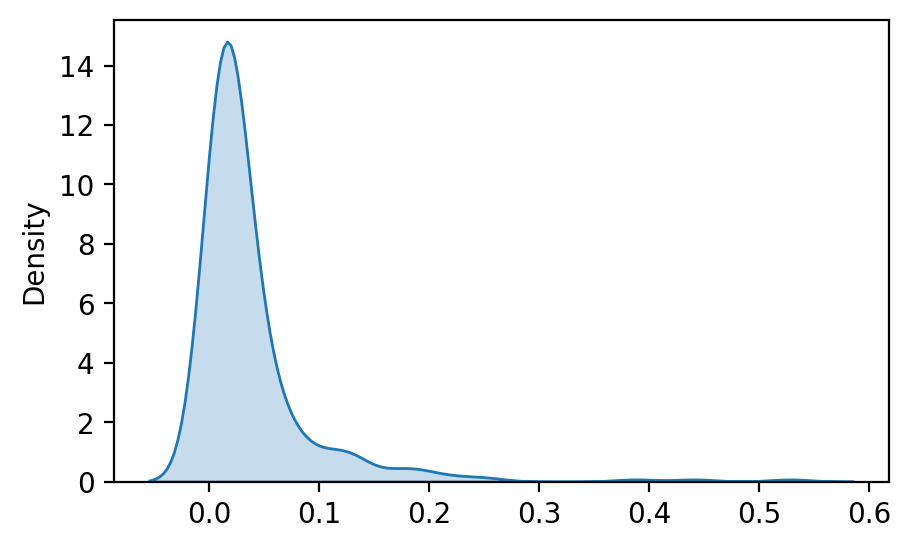

In [6]:
var_sr = gene_effect_filtered_df[hallmark_l].var(axis=0)
print(var_sr.shape)
MyVisualization.plot_distribution(var_sr)

In [7]:
hm_df = Clustering.drop_low_vars(gene_effect_filtered_df[hallmark_l], threshold=0.1)
hm_df.shape

(60, 27)

In [8]:
pref_file = 'Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv'
pref_l = MyLib.load_csv(pref_file, index_col=0).index.tolist()
pref_l = [g for g in pref_l if g in gene_effect_filtered_df.columns]
len(pref_l)

input_data/Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv  is loaded, shape:  (696, 1)



620

In [9]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
threshold = np.percentile(lrt_df['lrt'].dropna(), 98)

genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['name'].tolist() if g in gene_effect_filtered_df.columns]
gene_effect_lrt_df = gene_effect_filtered_df[genes_lrt_l]
gene_effect_lrt_df.shape

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



(60, 193)

In [10]:
genes_l = sorted(set(pref_l).union(var_df.columns.tolist()).union(set(hm_df.columns)).union(gene_effect_lrt_df.columns))
gene_effect_filtered_df2 = gene_effect_filtered_df[genes_l].copy()

gene_effect_filtered_df2.shape

(60, 772)

In [11]:
encoder = ce.OneHotEncoder(use_cat_names=True)
subtype_df = encoder.fit_transform(upset_df['Subtype'])
subtype_df

,Subtype_AC,Subtype_ECC,Subtype_GBC,Subtype_HCC,Subtype_ICC
Cell_line,,,,,
SNU869,1,0,0,0,0
SNU478,1,0,0,0,0
TGBC52TKB,1,0,0,0,0
AOVC1,1,0,0,0,0
TGBC18TKB,1,0,0,0,0
SNU1196,0,1,0,0,0
EGI1,0,1,0,0,0
KKU100,0,1,0,0,0
TFK1,0,1,0,0,0


# Subtype differential dependency

## AC

In [12]:
group =  'Subtype_AC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_AC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_AC_all_features_stats.csv saved, shape: (772, 6)


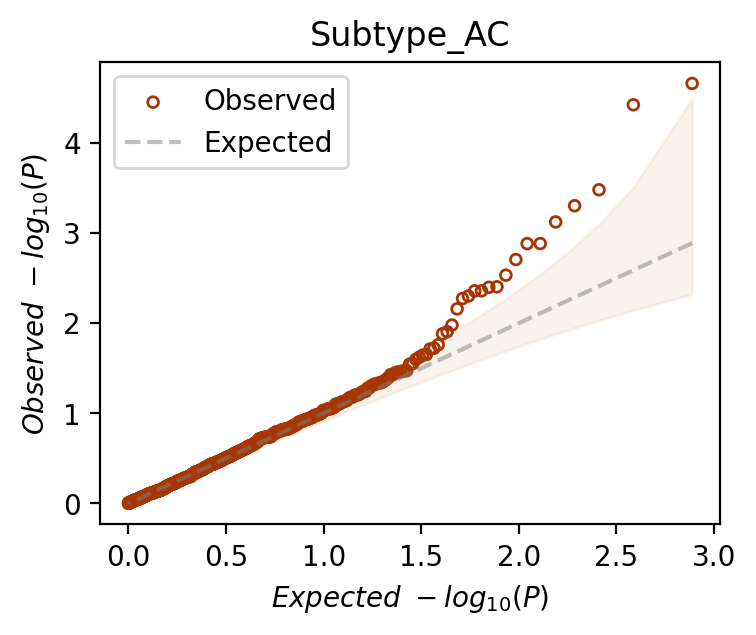

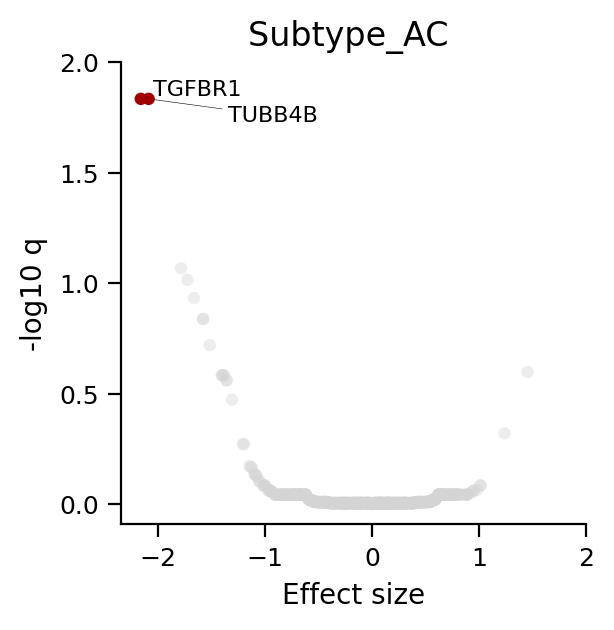


File  Figure4/output_fig4/Subtype_AC_features_Down_.csv saved, shape: (2, 5)


In [13]:
AC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=2, ytick_step=.5, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## ECC

In [14]:
group =  'Subtype_ECC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_ECC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_ECC_all_features_stats.csv saved, shape: (772, 6)


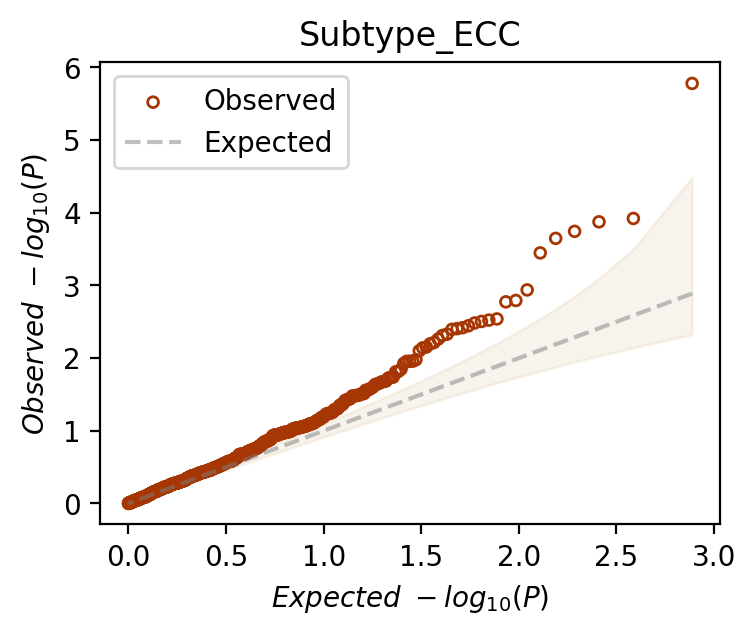

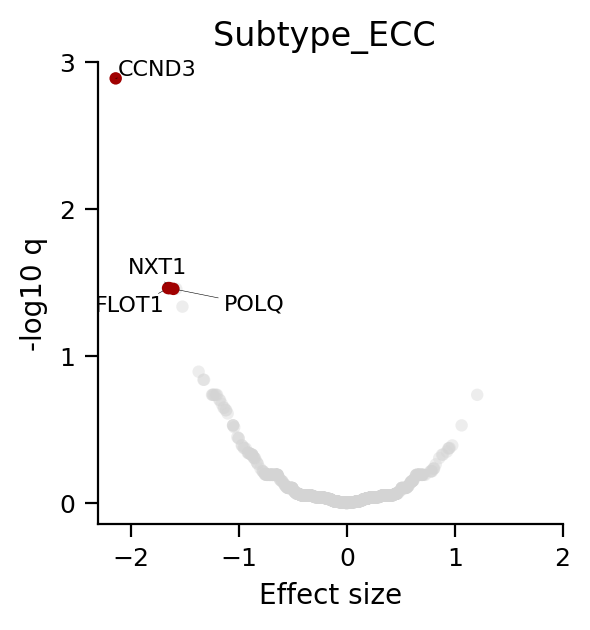


File  Figure4/output_fig4/Subtype_ECC_features_Down_.csv saved, shape: (4, 5)


In [15]:
ECC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=3, ytick_step=1, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## GBC

In [16]:
group =  'Subtype_GBC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_GBC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_GBC_all_features_stats.csv saved, shape: (772, 6)


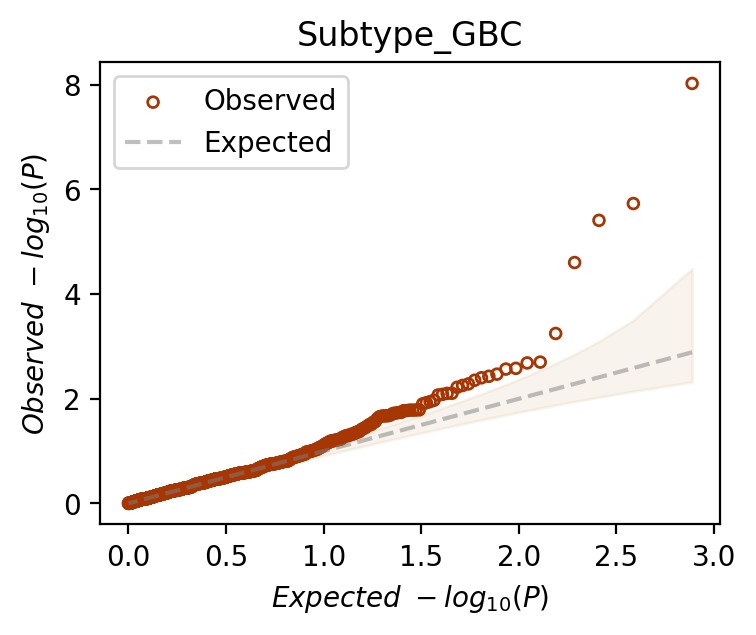

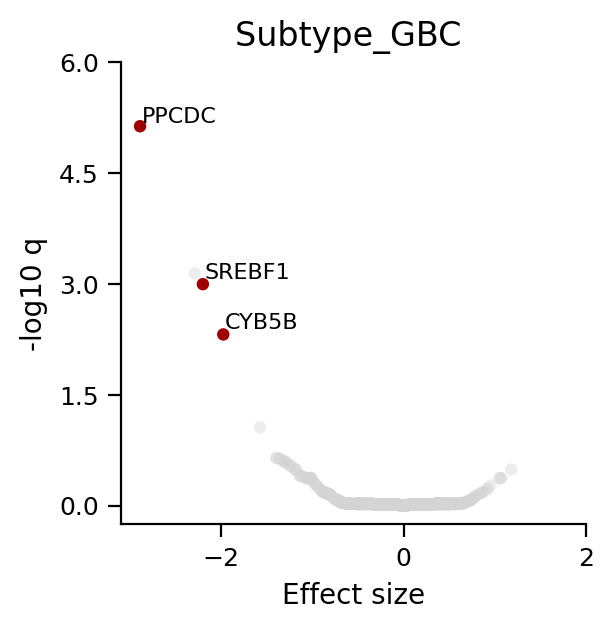


File  Figure4/output_fig4/Subtype_GBC_features_Down_.csv saved, shape: (3, 5)


In [17]:
GBC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=6, ytick_step=1.5, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## ICC

In [18]:
group =  'Subtype_ICC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_ICC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_ICC_all_features_stats.csv saved, shape: (772, 6)


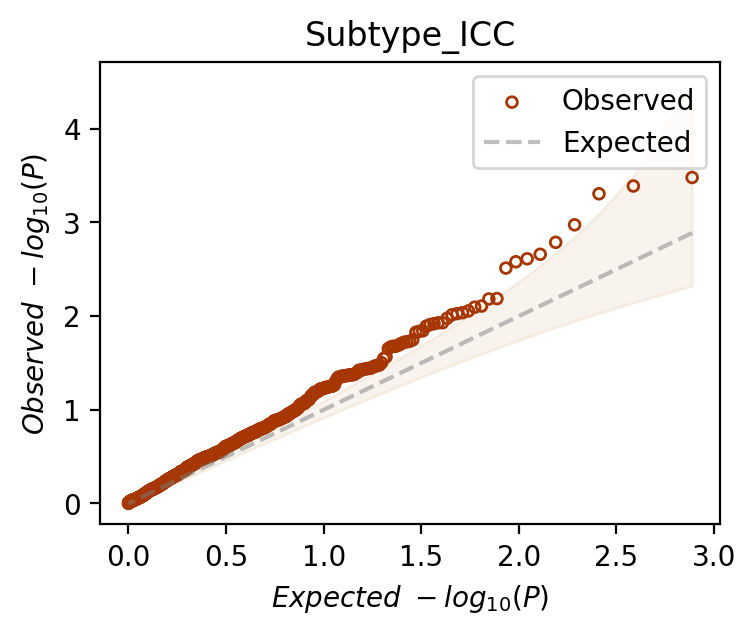

In [19]:
ICC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=6, ytick_step=1.5, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## HCC

In [20]:
group =  'Subtype_HCC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_HCC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_HCC_all_features_stats.csv saved, shape: (772, 6)


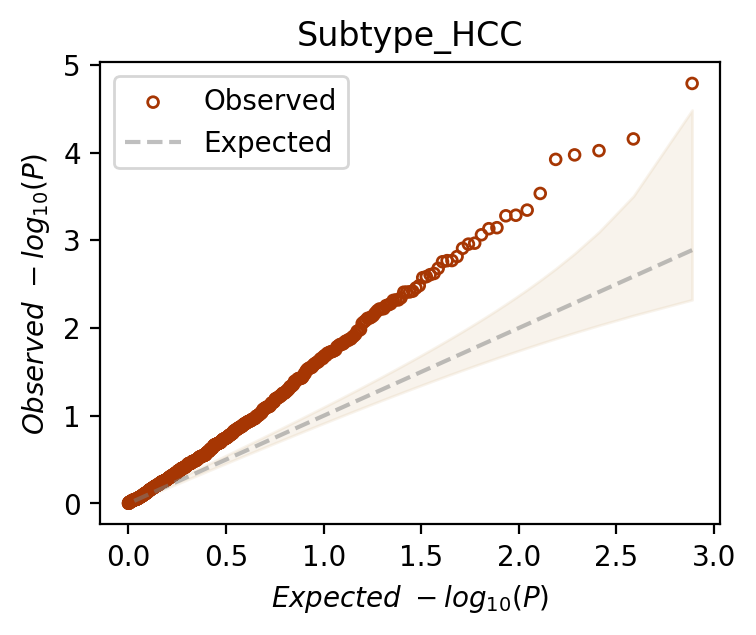

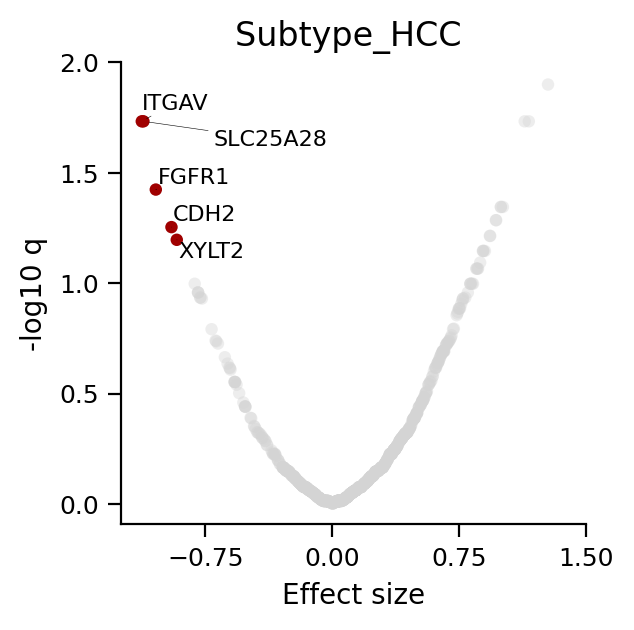


File  Figure4/output_fig4/Subtype_HCC_features_Down_.csv saved, shape: (5, 5)


In [21]:
HCC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', gene_effect_thr=None, return_features=True,  ylim_top=2, ytick_step=.5, xlim_right=1.5, xtick_step=.75, top_labels_cutoff=2)

# Heatmap of selected features

In [22]:
features_l = GBC_features+AC_features+ECC_features+HCC_features
features_l.remove('CDH2')
features_l.remove('SLC25A28')
features_l

['SREBF1',
 'CYB5B',
 'PPCDC',
 'TUBB4B',
 'TGFBR1',
 'NXT1',
 'CCND3',
 'POLQ',
 'FLOT1',
 'ITGAV',
 'XYLT2',
 'FGFR1']

Minimum value for all clusters:
Gene
SREBF1   -1.313944
TUBB4B   -1.282492
NXT1     -1.127758
ITGAV    -0.928249
CYB5B    -0.893537
PPCDC    -0.803778
TGFBR1   -0.618958
CCND3    -0.614579
POLQ     -0.604770
FLOT1    -0.505690
XYLT2    -0.457736
FGFR1    -0.416531
dtype: float64


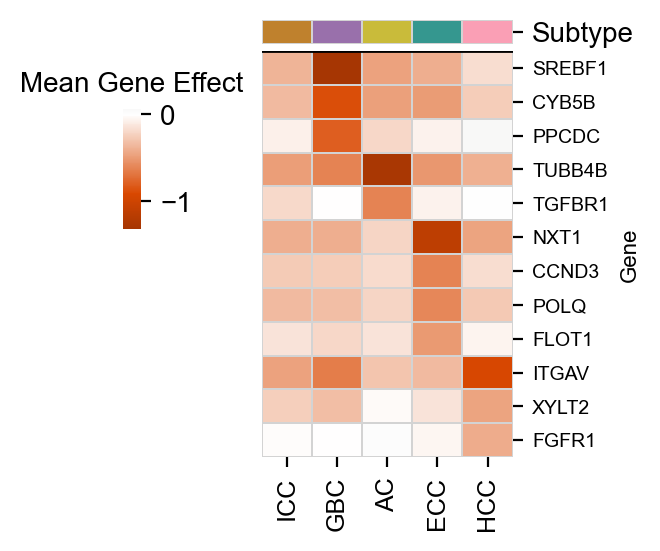

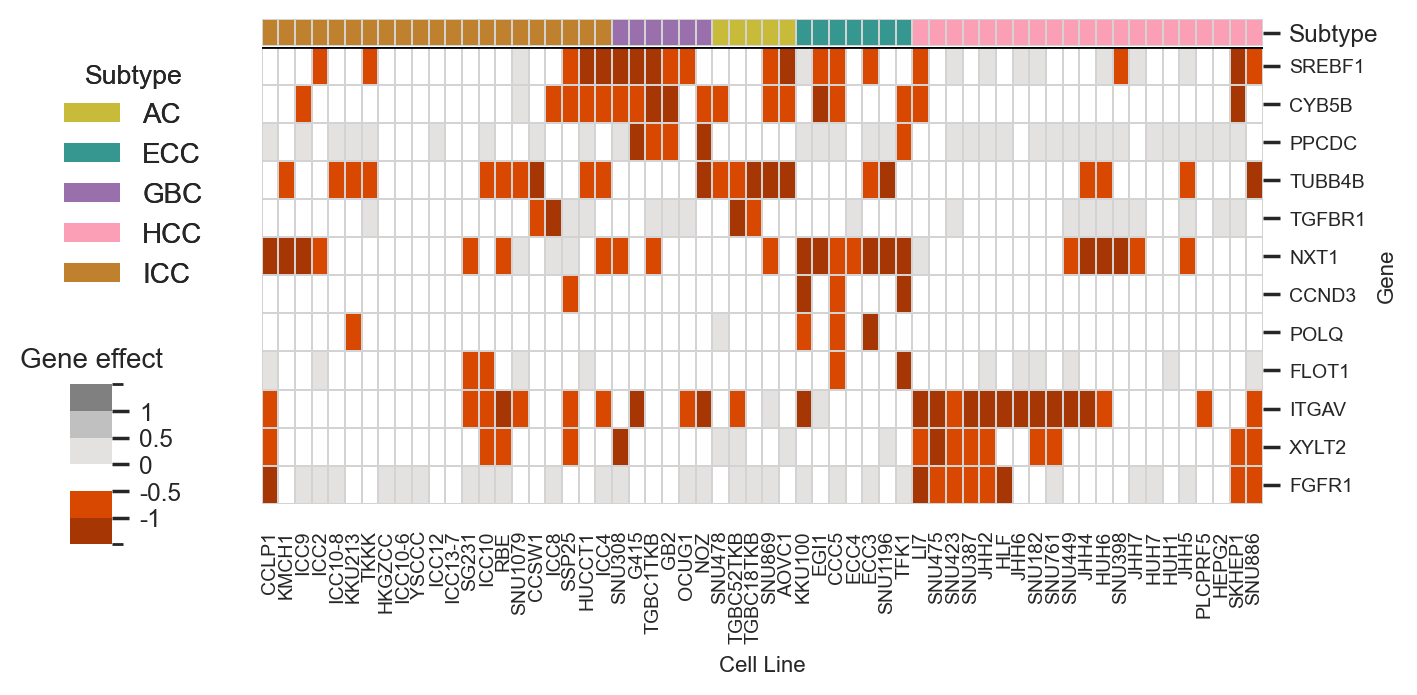

In [23]:
clusters_ordering = ['ICC', 'GBC', 'AC', 'ECC', 'HCC']
Clustering.plot_heatmaps_subtypes(gene_effect_filtered_df2.loc[:, features_l], upset_df, clusters_ordering, save_figure=True)

# Load DepMap Dataset

In [24]:
ccle_cripsr_file = 'Additional_Data/DepMap/CRISPRGeneEffect.csv'
ccle_crispr_df = MyLib.load_csv(ccle_cripsr_file, index_col=0)
ccle_crispr_df = ccle_crispr_df.dropna(axis=1)
ccle_crispr_df = ccle_crispr_df.rename(columns={c:c.split(' (')[0] for c in ccle_crispr_df.columns})
print(f'ccle_crispr_df shape:{ccle_crispr_df.shape}')

input_data/Additional_Data/DepMap/CRISPRGeneEffect.csv  is loaded, shape:  (1100, 18443)

ccle_crispr_df shape:(1100, 17107)


In [25]:
btc_upset_df = raw_upset_df[(raw_upset_df['CRISPR'] == 1) & (raw_upset_df['Subtype'] != 'HCC')]
ccle_crispr_filtered_df, gene_effect_filtered_df3 = Utils.match_columns_df(ccle_crispr_df, gene_effect_filtered_df2) # keep the same set of hypotheses as the subtype-specific analyses
print('ccle_crispr_filtered_df shape:', ccle_crispr_filtered_df.shape)

ccle_crispr_filtered_df shape: (1100, 771)


# GBC vs other DepMap

In [26]:
gbc_upset_df = btc_upset_df[btc_upset_df['Subtype'] == 'GBC']
print(f'number of GBC lines: {len(gbc_upset_df)}')
gbc_crispr_df = gene_effect_filtered_df3.loc[gbc_upset_df.index]
other_ccle_crispr_filtered_df = ccle_crispr_filtered_df[~ccle_crispr_filtered_df.index.isin(gbc_upset_df['DepMap_ID'])]
print(f'other_ccle_crispr_df shape:{other_ccle_crispr_filtered_df.shape}')
crispr_data_df = pd.concat([other_ccle_crispr_filtered_df, gbc_crispr_df], axis=0)
cur_upset_df = pd.DataFrame([0]*other_ccle_crispr_filtered_df.shape[0]+[1]*gbc_crispr_df.shape[0], index=other_ccle_crispr_filtered_df.index.tolist()+gbc_crispr_df.index.tolist(), columns=['GBC'])
crispr_data_df.shape

number of GBC lines: 6
other_ccle_crispr_df shape:(1094, 771)


(1100, 771)

In [27]:
group =  'GBC'
res_df = DifferentialDependency.differential_dependency(crispr_data_df, cur_upset_df, test='ttest', group=group)
res_df.head()

GBC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/GBC_all_features_stats.csv saved, shape: (771, 6)


,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
0,SREBF1,7.426089e-13,-2.971113,5.725514e-10,-1.313944,-0.292287
1,PPCDC,2.085643e-08,-2.311434,8.040155e-06,-0.803778,-0.104260
2,DNAI7,3.402873e-08,-2.275716,8.745384e-06,-0.432734,-0.033405
3,LMNTD1,8.321981e-08,-2.209145,1.604062e-05,-0.270261,-0.037000
4,DLGAP1,5.406092e-07,-2.063722,8.336194e-05,-0.073063,0.119552


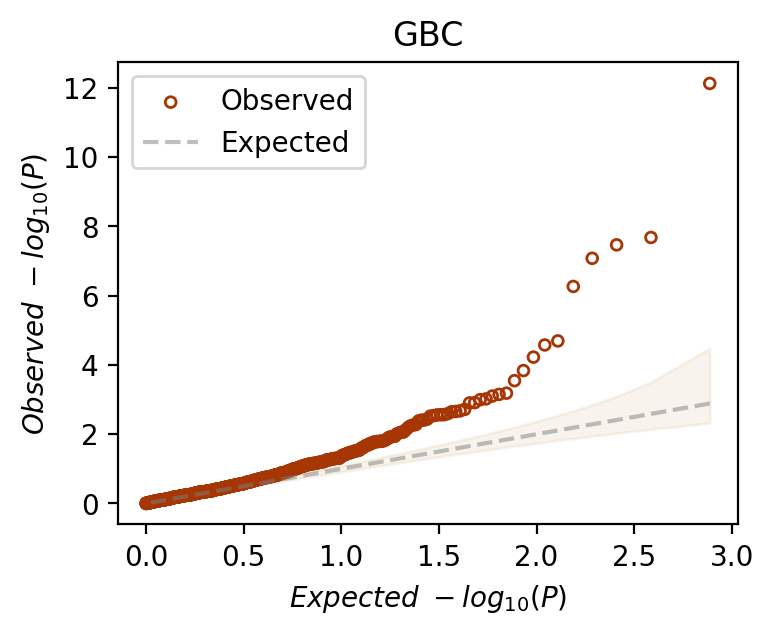

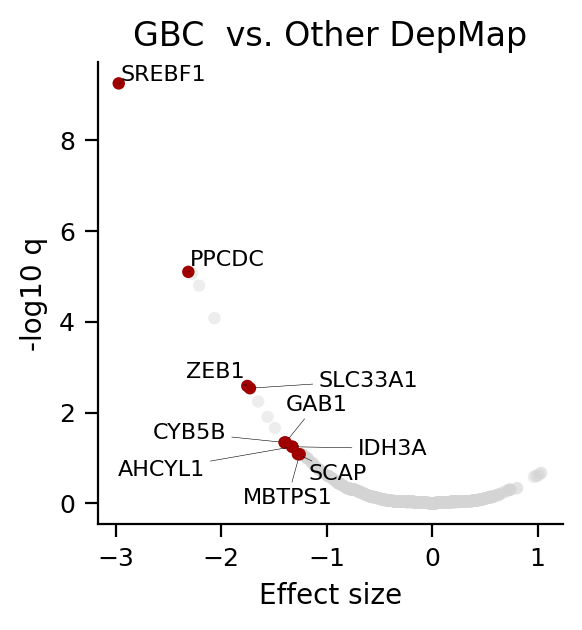


File  Figure4/output_fig4/GBC_features_Down_ vs. Other DepMap.csv saved, shape: (10, 5)


In [28]:
_ = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', title=' vs. Other DepMap', return_features=True)

## SREBF1

In [29]:
res_df[res_df['feature']=='SREBF1']

,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
0,SREBF1,7.426089e-13,-2.971113,5.725514e-10,-1.313944,-0.292287


Figure4/output_fig4/SREBF1_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

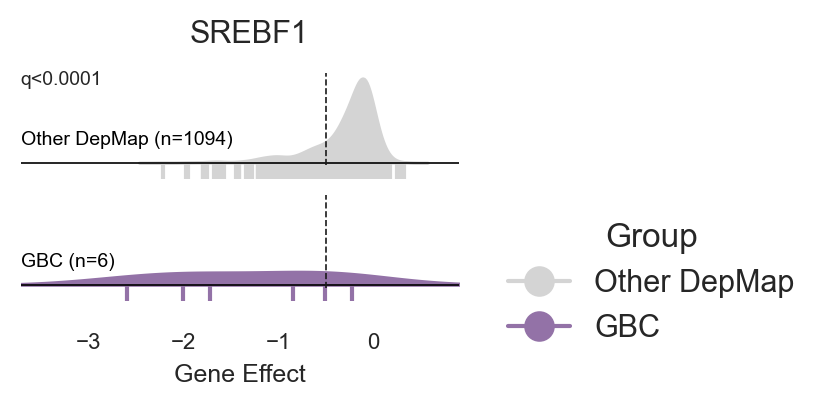

In [30]:
gene = 'SREBF1'
q_val = res_df[res_df['feature']==gene]['q-value'].values[0]
color_dic = {'Other DepMap': {'Other DepMap': '#d4d4d4'}, 'GBC':{'GBC': '#9372A7'}}
color_rug_dic = color_dic
df, _ = Utils.prepare_data_for_hue_plots(crispr_data_df[[gene]], gbc_upset_df, label1='GBC', label2='Other DepMap')
df = df.rename(columns={'value': 'Gene Effect'})
MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_left=-3.7, xlim_right=.9, aspect=4, title=gene, p_value_l=[q_val], fdr=True, sig_thr=0.1, vline_offset=0.17, rug_plot_height=0.4, xtick_step=1, levels_fontsize=7, label_fontsize=9, tick_fontsize=8, file_name=gene)

## PPCDC

In [31]:
res_df[res_df['feature']=='PPCDC']

,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
1,PPCDC,2.085643e-08,-2.311434,0.000008,-0.803778,-0.10426


Figure4/output_fig4/PPCDC_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

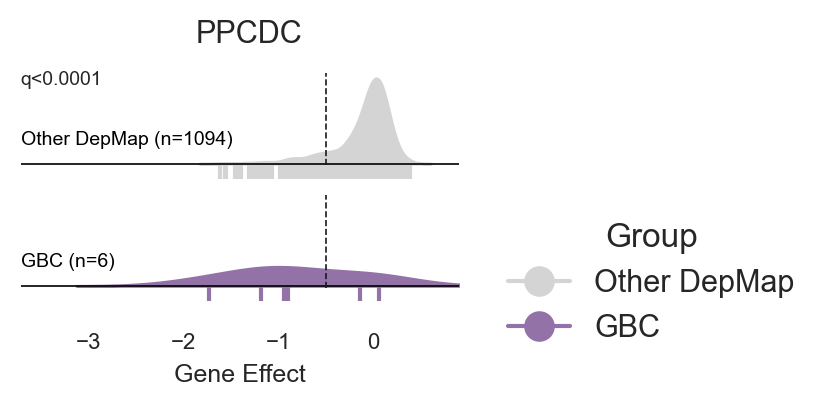

In [32]:
gene = 'PPCDC'
q_val = res_df[res_df['feature']==gene]['q-value'].values[0]
color_dic = {'Other DepMap': {'Other DepMap': '#d4d4d4'}, 'GBC':{'GBC': '#9372A7'}}
color_rug_dic = color_dic
df, _ = Utils.prepare_data_for_hue_plots(crispr_data_df[[gene]], gbc_upset_df, label1='GBC', label2='Other DepMap')
df = df.rename(columns={'value': 'Gene Effect'})
MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_left=-3.7, xlim_right=.9, aspect=4, title=gene, p_value_l=[q_val], fdr=True, sig_thr=0.1, vline_offset=0.17, rug_plot_height=0.4, xtick_step=1, levels_fontsize=7, label_fontsize=9, tick_fontsize=8, file_name=gene)

# AC vs other DepMap

In [33]:
ac_upset_df = btc_upset_df[btc_upset_df['Subtype'] == 'AC']
print(f'number of AC lines: {len(ac_upset_df)}')
ac_crispr_df = gene_effect_filtered_df3.loc[ac_upset_df.index]
other_ccle_crispr_filtered_df = ccle_crispr_filtered_df[~ccle_crispr_filtered_df.index.isin(ac_upset_df['DepMap_ID'])]
print(f'other_ccle_crispr_df shape:{other_ccle_crispr_filtered_df.shape}')
crispr_data_df = pd.concat([other_ccle_crispr_filtered_df, ac_crispr_df], axis=0)
cur_upset_df = pd.DataFrame([0]*other_ccle_crispr_filtered_df.shape[0]+[1]*ac_upset_df.shape[0], index=other_ccle_crispr_filtered_df.index.tolist()+ac_upset_df.index.tolist(), columns=['AC'])
crispr_data_df.shape

number of AC lines: 5
other_ccle_crispr_df shape:(1095, 771)


(1100, 771)

In [34]:
group =  'AC'
res_df = DifferentialDependency.differential_dependency(crispr_data_df, cur_upset_df, test='ttest', group=group)
res_df.head()

AC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/AC_all_features_stats.csv saved, shape: (771, 6)


,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
0,TUBB4B,4.524117e-08,-2.468777,0.000035,-1.282492,-0.413952
1,TGFBR1,5.936413e-06,-2.039872,0.002288,-0.618958,-0.134834
2,GGNBP2,2.538431e-05,-1.895753,0.006524,-0.822330,-0.306387
3,LDHA,3.709051e-05,-1.856527,0.007149,-0.666704,-0.322691
4,MARK3,5.310196e-05,-1.818727,0.008188,-0.292580,-0.015751


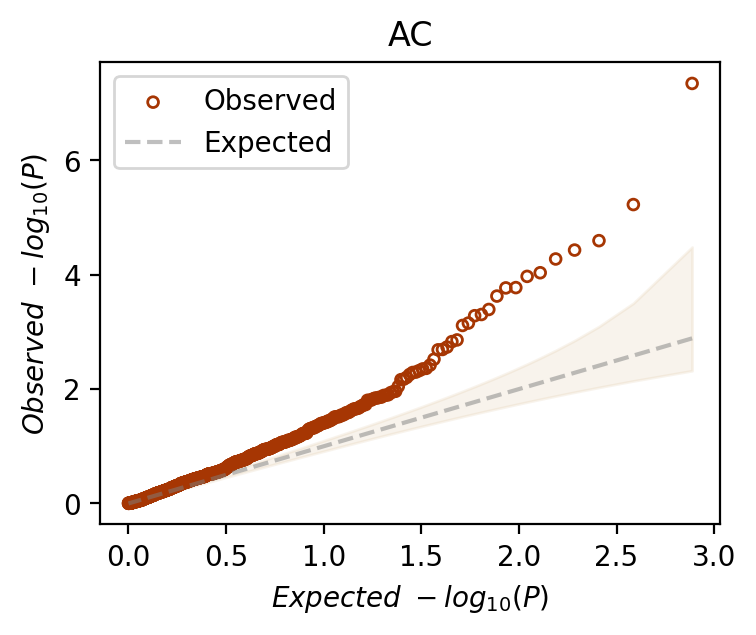

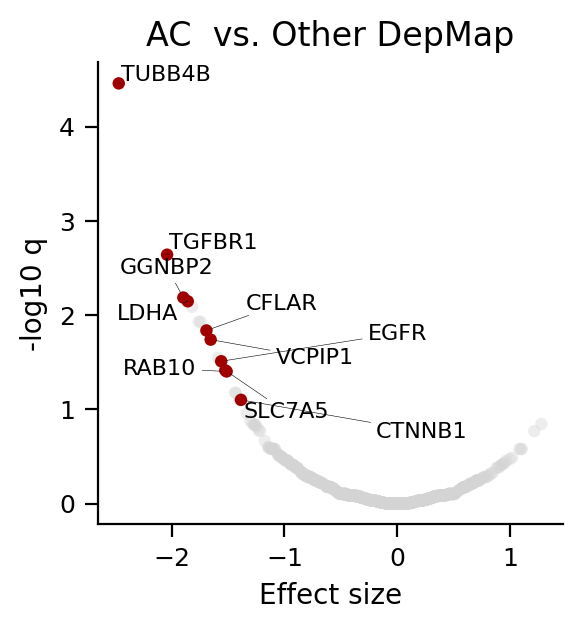


File  Figure4/output_fig4/AC_features_Down_ vs. Other DepMap.csv saved, shape: (10, 5)


In [35]:
_ = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', title=' vs. Other DepMap',  return_features=True)

## TUBB4B

In [36]:
res_df[res_df['feature']=='TUBB4B']

,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
0,TUBB4B,4.524117e-08,-2.468777,0.000035,-1.282492,-0.413952


Figure4/output_fig4/TUBB4B_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

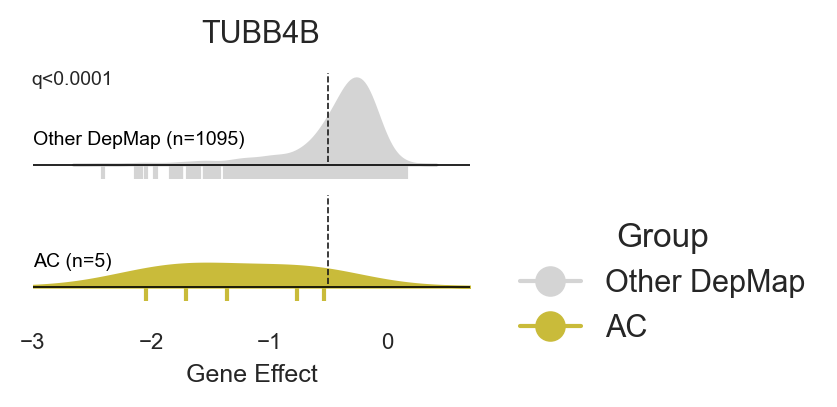

In [37]:
gene = 'TUBB4B'
q_val = res_df[res_df['feature']==gene]['q-value'].values[0]
color_dic = {'Other DepMap': {'Other DepMap': '#d4d4d4'}, 'AC':{'AC': '#c9bb3a'}}
color_rug_dic = color_dic
df, _ = Utils.prepare_data_for_hue_plots(crispr_data_df[[gene]], ac_upset_df, label1='AC', label2='Other DepMap')
df = df.rename(columns={'value': 'Gene Effect'})
MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_left=-3., xlim_right=.7, aspect=4, title=gene, p_value_l=[q_val], fdr=True, sig_thr=0.1, vline_offset=0.2, rug_plot_height=0.3, xtick_step=1, levels_fontsize=7, label_fontsize=9, tick_fontsize=8, file_name=gene)

## SLC7A5

In [38]:
res_df[res_df['feature']=='SLC7A5']

,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
13,SLC7A5,0.000701,-1.523488,0.038602,-0.818812,-0.273549


Figure4/output_fig4/SLC7A5_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

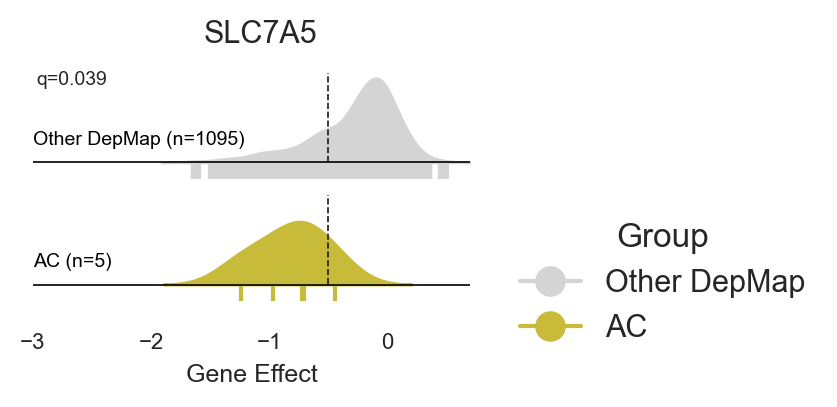

In [39]:
gene = 'SLC7A5'
q_val = res_df[res_df['feature']==gene]['q-value'].values[0]
color_dic = {'Other DepMap': {'Other DepMap': '#d4d4d4'}, 'AC':{'AC': '#c9bb3a'}}
color_rug_dic = color_dic
df, _ = Utils.prepare_data_for_hue_plots(crispr_data_df[[gene]], ac_upset_df, label1='AC', label2='Other DepMap')
df = df.rename(columns={'value': 'Gene Effect'})
MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_left=-3., xlim_right=.7, aspect=4, title=gene, p_value_l=[q_val], fdr=True, sig_thr=0.1, vline_offset=0.2, rug_plot_height=0.3, xtick_step=1, levels_fontsize=7, label_fontsize=9, tick_fontsize=8, file_name=gene)

# ECC vs other DepMap

In [40]:
ecc_upset_df = btc_upset_df[btc_upset_df['Subtype'] == 'ECC']
print(f'number of ECCC lines: {len(ecc_upset_df)}')
ecc_crispr_df = gene_effect_filtered_df3.loc[ecc_upset_df.index]
other_ccle_crispr_filtered_df = ccle_crispr_filtered_df[~ccle_crispr_filtered_df.index.isin(ecc_upset_df['DepMap_ID'])]
print(f'other_ccle_crispr_df shape:{other_ccle_crispr_filtered_df.shape}')
crispr_data_df = pd.concat([other_ccle_crispr_filtered_df, ecc_crispr_df], axis=0)
cur_upset_df = pd.DataFrame([0]*other_ccle_crispr_filtered_df.shape[0]+[1]*ecc_upset_df.shape[0], index=other_ccle_crispr_filtered_df.index.tolist()+ecc_upset_df.index.tolist(), columns=['ECC'])
crispr_data_df.shape

number of ECCC lines: 7
other_ccle_crispr_df shape:(1093, 771)


(1100, 771)

In [41]:
group =  'ECC'
res_df = DifferentialDependency.differential_dependency(crispr_data_df, cur_upset_df, test='ttest', group=group)
res_df.head()

ECC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/ECC_all_features_stats.csv saved, shape: (771, 6)


,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
0,FLOT1,6.137953e-09,-2.221694,0.000005,-0.505690,-0.098873
1,DUSP1,3.032292e-06,-1.779444,0.001169,-0.302757,-0.019841
2,TNPO2,6.706178e-05,-1.517397,0.017235,-0.240453,-0.077489
3,EPS8L2,1.400252e-04,-1.449050,0.026990,-0.319431,-0.155240
4,PPARG,1.902379e-04,-1.419759,0.029335,-0.231320,0.015630


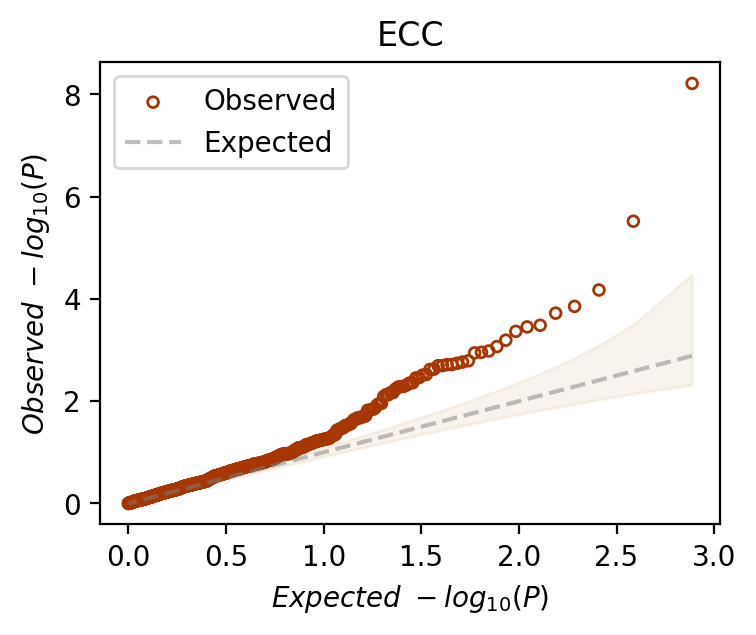

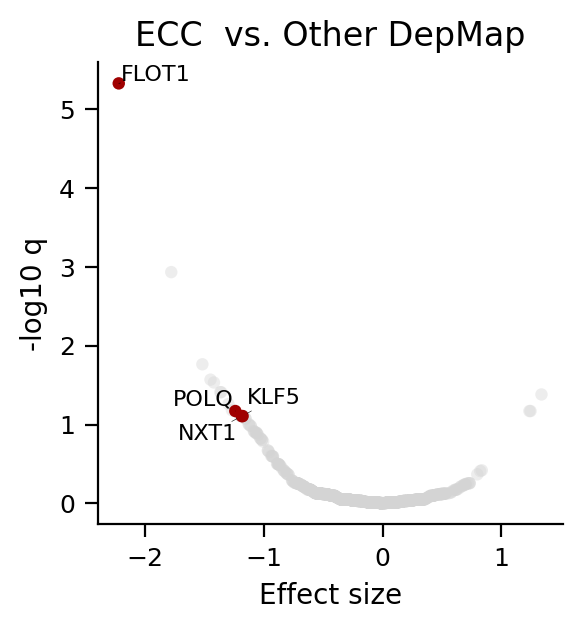


File  Figure4/output_fig4/ECC_features_Down_ vs. Other DepMap.csv saved, shape: (4, 5)


In [42]:
_ = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', title=' vs. Other DepMap',  return_features=True)

## NXT1

In [43]:
res_df[res_df['feature']=='NXT1']

,feature,p-value,effect_size,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean
15,NXT1,0.001819,-1.185256,0.078206,-1.127758,-0.515322


Figure4/output_fig4/NXT1_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

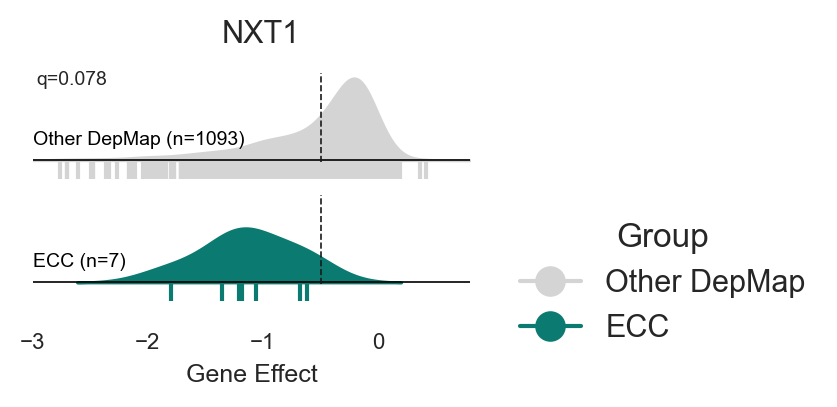

In [44]:
gene = 'NXT1'
q_val = res_df[res_df['feature']==gene]['q-value'].values[0]
color_dic = {'Other DepMap': {'Other DepMap': '#d4d4d4'}, 'ECC':{'ECC': '#0b7a71'}}
color_rug_dic = color_dic
df, _ = Utils.prepare_data_for_hue_plots(crispr_data_df[[gene]], ecc_upset_df, label1='ECC', label2='Other DepMap')
df = df.rename(columns={'value': 'Gene Effect'})
MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_left=-3., xlim_right=.8, aspect=4, title=gene, p_value_l=[q_val], fdr=True, sig_thr=0.1, vline_offset=0.2, rug_plot_height=0.3, xtick_step=1, levels_fontsize=7, label_fontsize=9, tick_fontsize=8, file_name=gene)